In [1]:
class tsa_econometrics:
    def __init__(self,variable,deter):
        self.variable=variable
        self.deter=deter
        
    def level_results(self): #Box-Jenkins
        import pandas as pd
        import numpy as np
        variable=np.log(self.variable)
        from statsmodels.tsa import stattools
        cond=["ct","c","nc"]
        conta=0
        estacio=[]
        for p in cond:
            estacio.append(np.array(stattools.adfuller(variable, maxlag=None, regression=p,autolag='AIC'))[1])
        dickey_level=pd.DataFrame(estacio)
        dickey_level.index=cond
        integ_1=0
        integ_2=0
        stati=0
        if dickey_level.loc[self.deter,0]>=0.05:
            diff_1=pd.DataFrame(np.diff(variable,n=1))
            integ_1+=1
            if np.array(stattools.adfuller(diff_1, maxlag=None, regression=self.deter,autolag='AIC'))[1]>=0.05:
                diff_2=pd.DataFrame(np.diff(diff_1.dropna(),n=2))
                integ_2+=1
        else:
            stat=variable
            stati+=1
        if integ_2==1:
            variable_trat=diff_2.dropna()
        if integ_1==1:
            variable_trat=diff_1.dropna()
        if stati==1:
            variable_trat=stat
        print("Integration order 1: "+str(integ_1)+".",
             "Integration order 2: "+str(integ_2)+".",
             "Stationarity: "+str(stati)+".")
        self.variable_trat=variable_trat
        return dickey_level,variable_trat
    
    def plotting(self):
        from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
        import matplotlib.pyplot as plt
        fig, axes=plt.subplots(nrows=3, ncols=1,dpi=120,figsize=(13,13))
        axes[0].plot(self.variable_trat,color="blue") ; axes[0].set_title("Simple plotting")
        plot_acf(self.variable_trat,ax=axes[1],color="red") ; axes[1].set_title("Autocorrelation Function")
        plot_pacf(self.variable_trat,ax=axes[2],color="green") ; axes[2].set_title("Parcial Autocorrelation Function")
        plt.tight_layout()
    
    def selection_criteria(self,signif):
        from statsmodels.tsa.stattools import acf
        from statsmodels.tsa.stattools import pacf
        ac,conf_ac=acf(self.variable_trat,alpha=signif)
        pac,conf_pac=pacf(self.variable_trat,alpha=signif)
        import numpy as np
        conf_ac=pd.DataFrame(conf_ac)
        conf_pac=pd.DataFrame(conf_pac)
        margen_ac=np.where((conf_ac[0]<0)&(0<conf_ac[1]),0,1)
        margen_pac=np.where((conf_pac[0]<0)&(0<conf_pac[1]),0,1)
        contador=0
        ma=[]
        ar=[]
        for h in range(1,len(margen_ac)-1):
            contador+=1
            if margen_ac[h]==1:
                ma.append(contador)
        contador_2=0
        for p in range(1,len(margen_pac)-1):
            contador_2+=1
            if margen_pac[p]==1:
                ar.append(contador_2)
        print("Autoregresive lags: " +str(ar)+",", "Moving average lags: " +str(ma)+".")
    
    def resid_diag(self,autr,integ,mova):
        log=np.log(self.variable)
        import seaborn as sns
        from statsmodels.tsa.arima.model import ARIMA
        model0=ARIMA(log, order=(autr, integ, mova))
        model0_fit=model0.fit()
        pvalue_norm=model0_fit.test_normality(method="jarquebera")[0,1]
        if pvalue_norm<0.05:
            residuals=pd.DataFrame(model0_fit.resid)
            residuals.columns=["Resid"]
            print("There's one or more atypical residuals; two of them: "+"maximum: "+str(np.max(residuals[1:])[0])+".", 
                  "minimum: "+str(np.min(residuals[1:])[0]))
            fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,5))
            ax[0].plot(residuals[1:],color="black"); ax[0].set_title("Line plot of residuals")
            sns.histplot(residuals[1:],kde="True",ax=ax[1]); ax[1].set_title("Histogram of residuals")
            plt.tight_layout()
        self.log=log
        self.autr=autr
        self.integ=integ
        self.mova=mova
        self.residuals=residuals
        self.maximum=np.max(residuals)
        
    def fit_univariate(self,insert_dummy,maximum,minimum,lbox_lags):
        from statsmodels.tsa.arima.model import ARIMA
        max_dummy=pd.DataFrame(index=self.residuals.index)
        min_dummy=pd.DataFrame(index=self.residuals.index)
        max_dummy[0]=0
        min_dummy[0]=0
        maxi=np.max(self.residuals[self.integ+self.autr:])[0]
        mini=np.min(self.residuals[self.integ+self.autr:])[0]
        max_index=self.residuals.loc[self.residuals["Resid"]==maxi,:].index
        min_index=self.residuals.loc[self.residuals["Resid"]==mini,:].index
        max_dummy.loc[max_index,0]=1
        min_dummy.loc[min_index,0]=1
        array=np.arange(0,len(self.residuals))
        
        if insert_dummy=="True":
            if maximum=="True":
                model1=ARIMA(self.log, order=(self.autr, self.integ, self.mova),exog=max_dummy)
                model1_fit=model1.fit()
                print("Model with dummy of maximum residual")
                array=max_dummy
            else:
                if minimum=="True":
                    model1=ARIMA(self.log, order=(self.autr, self.integ, self.mova),exog=min_dummy)
                    model1_fit=model1.fit()
                    print("Model with dummy of minimum residual")
                    array=min_dummy
        else:
            model1=ARIMA(self.log, order=(self.autr, self.integ, self.mova))
            model1_fit=model1.fit()
            print("Model without dummy")
        
        self.minimum=minimum
        self.maximum=maximum
        self.insert_dummy=insert_dummy
        self.modelo=model1_fit
        self.array=array
        import statsmodels.api as sm
        ljung_box=sm.stats.acorr_ljungbox(model1_fit.resid,lags=[lbox_lags],return_df="True")
        
        return model1_fit, ljung_box, array
    
    def plot_predictions(self):
        predictions=pd.DataFrame()
        predictions[0]=np.exp(self.modelo.predict(start=self.autr+self.integ
                                                   ,end=len(self.variable)-1)) #sample prediction
        plt.plot(predictions[0],color="green",label="predictions")
        plt.plot(self.variable[self.autr+self.integ:],color="blue",label="real values")
        plt.legend()
        plt.show()
    
    def future_predict(self,fut_steps):
        if self.insert_dummy=="True":
            if self.maximum=="True":
                futures=np.exp(self.modelo.predict(start=len(self.log),end=len(self.log)+fut_steps,exog=self.array[-fut_steps-1:],dynamic=False))
            else:
                if self.minimum=="True":
                    futures=np.exp(self.modelo.predict(start=len(self.log),end=len(self.log)+fut_steps,exog=self.array[-fut_steps-1:],dynamic=False))
        else:
             futures=np.exp(self.modelo.predict(start=len(self.log),end=len(self.log)+fut_steps,dynamic=False))
        futures.plot()
        return futures

In [16]:
import warnings as wg
wg.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data=pd.read_excel("data.xlsx",index_col=0)
data.columns=["e","G","i","M1","y"]
objeto=tsa_econometrics(variable=data["i"],deter="c")

<AxesSubplot:xlabel='Período'>

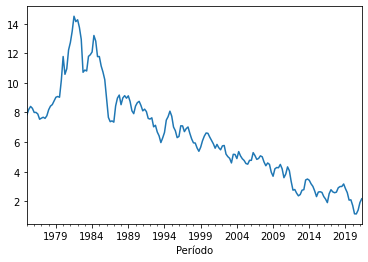

In [17]:
data["i"].plot()

In [18]:
dickey,new_data=objeto.level_results()
dickey

Integration order 1: 1. Integration order 2: 0. Stationarity: 0.


,0
ct,0.006402
c,0.872486
nc,0.213069


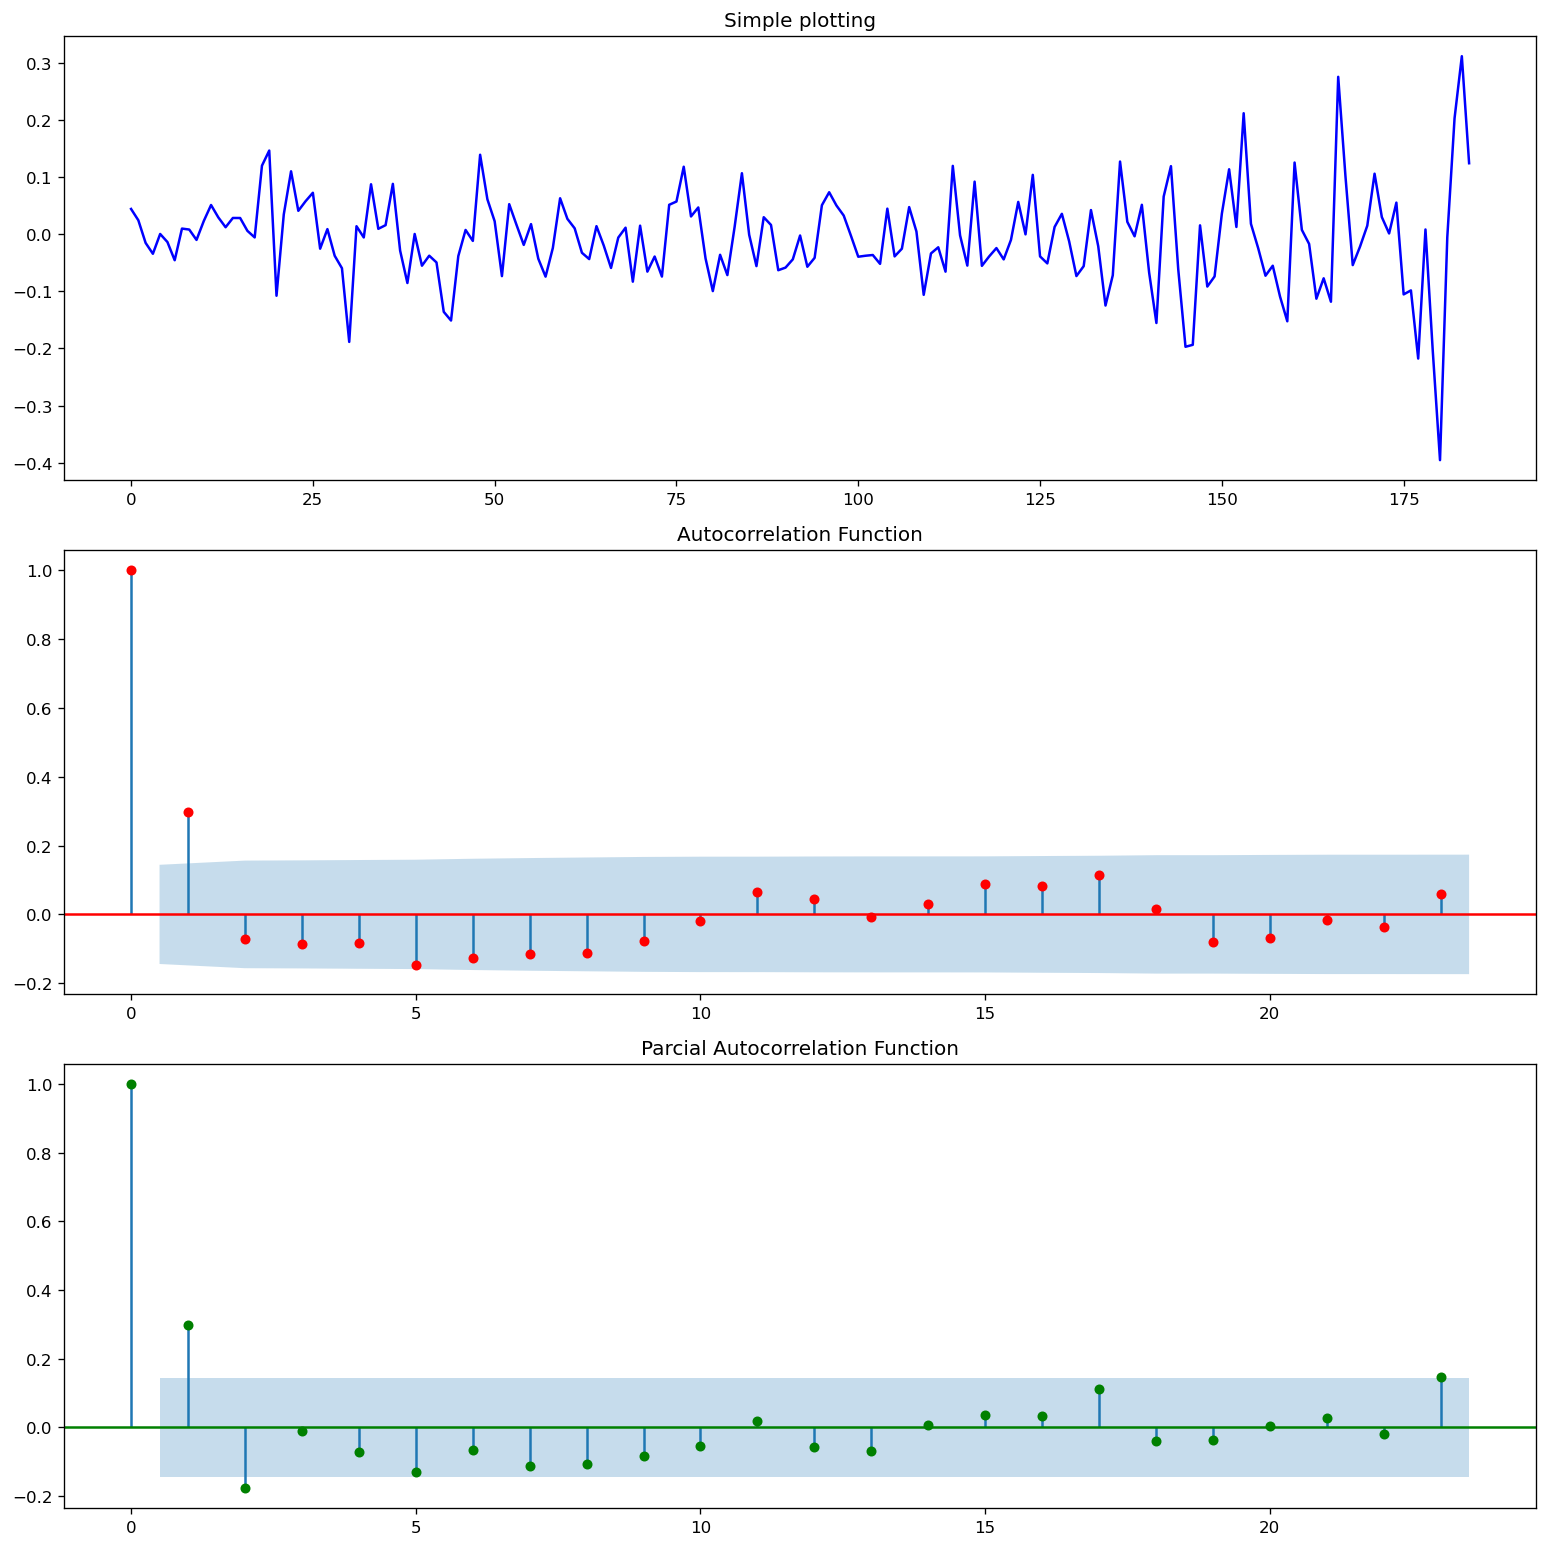

In [19]:
objeto.plotting()

In [20]:
objeto.selection_criteria(signif=0.05)

Autoregresive lags: [1, 2, 23], Moving average lags: [1].


There's one or more atypical residuals; two of them: maximum: 0.2861200641793413. minimum: -0.35973853655507854


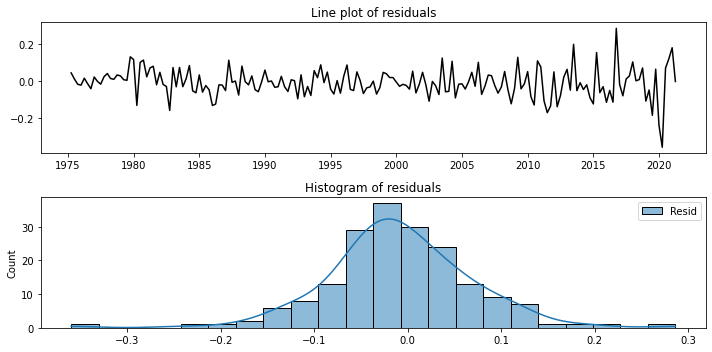

In [21]:
objeto.resid_diag(2,1,1)

In [22]:
modelo,lbox,dummy=objeto.fit_univariate(insert_dummy="True",maximum="False",minimum="True",lbox_lags=16)
modelo.summary()

Model with dummy of minimum residual


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      i   No. Observations:                  186
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 213.856
Date:                Sat, 22 Jan 2022   AIC                           -417.711
Time:                        16:34:19   BIC                           -401.609
Sample:                    01-01-1975   HQIC                          -411.185
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1401      0.023     -6.177      0.000      -0.185      -0.096
ar.L1          1.1143      0.150      7.431      0.000       0.820       1.408
ar.L2         -0.3620      0.061     -5.930      0.000      -0.482      -0.242
ma.L1         -0.8062      0.145     -5.578      0.000      -1.089      -0.523
sigma2         0.0058      0.001     10.687      0.000       0.005       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                17.40
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

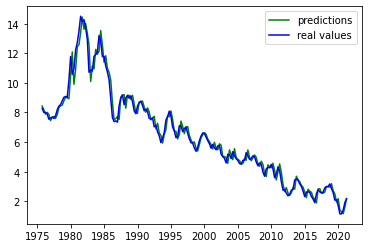

In [23]:
objeto.plot_predictions()

2021-07-01    2.231999
2021-10-01    2.203335
2022-01-01    2.149358
2022-04-01    2.100574
2022-07-01    2.065987
2022-10-01    2.045045
2023-01-01    2.034149
2023-04-01    2.029549
2023-07-01    2.028354
2023-10-01    2.028686
2024-01-01    2.029488
2024-04-01    1.764864
2024-07-01    2.030835
2024-10-01    2.031192
2025-01-01    2.031383
2025-04-01    2.031467
Freq: QS-OCT, Name: predicted_mean, dtype: float64

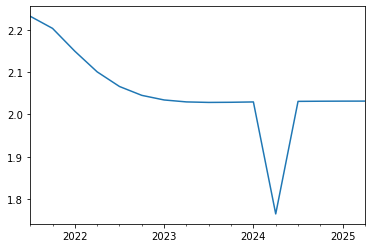

In [24]:
futuros=objeto.future_predict(15)
futuros